<a href="https://colab.research.google.com/github/Lemonfry/ds-section1-project/blob/main/section1-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

게임 개발을 위한 데이터 분석

---


목표 : 제일 잘 팔리는 게임 만들기

가진 데이터 : 무슨 장르의 게임이 어느 년도에 어떤 기종(platform)으로 출시되었으며, 만든 회사는 어디고 북미/유럽/일본/기타 지역에서의 출고 실적(

단순하게 생각한다면 가장 많이 팔리는 장르만 확인하여 모든 게임 기종으로 모든 지역에 판매하면 되겠으나, 개발 시간 제한 및 비용의 이유로 인해 그러기는 힘듭니다. 

그래서 잘 팔리는 게임을 위해선

1. 가장 많이 팔리는 장르
2. 가장 많이 팔리는 기종
3. 가장 많이 팔리는 지역

을 확인해야 합니다.

(분석을 위해, 출고량이 높으면 판매량도 많다고 생각하겠습니다)

진행 과정에 따른 설명은 코드를 참조해 주세요
1. 데이터 전처리(EDA)

In [ ]:
# 기종 항목이 누락되어 한칸씩 당겨진 2개의 항목이 있어,(7597번, 16192번) 직접 수정합니다.
# 마찬가지로 연도가 네자리가 아닌 경우들도 직접 수정합니다.(14 -> 2014, 99 -> 1999, 0 -> 2000 등)

In [ ]:
# 개인 노트북에 저장한 파일 불러오기
from google.colab import files
myfile = files.upload()

Saving vgames2_modified.csv to vgames2_modified.csv


In [ ]:
import io
import pandas as pd
game_data = pd.read_csv(io.BytesIO(myfile['vgames2_modified.csv']))

In [ ]:
# 데이터셋 확인(잘 불러와졌는지)
game_data

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04
...,...,...,...,...,...,...,...,...,...,...
16593,16594,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0,0.01
16594,16595,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0,0,0
16595,16596,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16596,16597,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03


In [ ]:
# 현재 주어진 표에서, 게임 이름이나 게임 출판사와 출고량간에 관계가 있는지는 '다음 분기 게임 설계'를 위한 분석을 할 때는 별 필요가 없다고 판단됩니다.
# (EA 등의 소위 덩치가 큰 출판사가 당연히 더 많은 게임을 출고했겠으나, 게임을 만드는 입장에선 딱히 쓸모가 없는 정보입니다.)
# unamed:0와 사용하지 않을 게임 이름(name)과 출판사(publisher) column을 제거합니다
game_data = game_data.drop(['Unnamed: 0','Name','Publisher'], axis = 1)

In [ ]:
game_data

,Platform,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,DS,2008.0,Action,0.04,0,0,0
1,Wii,2009.0,Action,0.17,0,0,0.01
2,PSP,2010.0,Adventure,0,0,0.02,0
3,DS,2010.0,Misc,0.04,0,0,0
4,PS3,2010.0,Platform,0.12,0.09,0,0.04
...,...,...,...,...,...,...,...
16593,GC,2006.0,Platform,0.15,0.04,0,0.01
16594,PSP,2005.0,Action,0.01,0,0,0
16595,PS3,2015.0,Sports,0.44,0.19,0.03,0.13
16596,PSV,2013.0,Action,0.05,0.05,0.25,0.03


In [ ]:
# Sales 항목의 수를 M(백만) 단위로 맞추기 : 여러 게임 관련 기사를 볼 때, 출고량의 기본 단위는 M이며 단위가 누락된 게임들도 M 단위 출고량에 더 가까운 것으로 보입니다.
# (단위 없는 판매량 중 1985 슈퍼마리오의 출고량이 41.49인데, 가디언지 온라인 기사에서 4000만장(40M) 팔렸단 기사로 볼때 M으로 계산 가능할 것으로 생각됨)
# https://www.theguardian.com/technology/gamesblog/2010/sep/13/games-gameculture, 10번항목
# 결론 : 단위 없으면 M으로 계산, K 단위는 M으로 변환합니다.

In [ ]:
# M단위 통일을 위해 M단위는 문자만 없애고, K단위 발견시 K는 없애고 0.001을 곱합니다.
game_data.NA_Sales = (game_data.NA_Sales.replace(r'[KM]+$', '', regex=True).astype(float)*
                      game_data.NA_Sales.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [0.001, 1]).astype(float))
game_data.EU_Sales = (game_data.EU_Sales.replace(r'[KM]+$', '', regex=True).astype(float)*
                      game_data.EU_Sales.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [0.001, 1]).astype(float))
game_data.JP_Sales = (game_data.JP_Sales.replace(r'[KM]+$', '', regex=True).astype(float)*
                      game_data.JP_Sales.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [0.001, 1]).astype(float))
game_data.Other_Sales = (game_data.Other_Sales.replace(r'[KM]+$', '', regex=True).astype(float)*
                         game_data.Other_Sales.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [0.001, 1]).astype(float))

In [ ]:
game_data

,Platform,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,DS,2008.0,Action,0.04,0.00,0.00,0.00
1,Wii,2009.0,Action,0.17,0.00,0.00,0.01
2,PSP,2010.0,Adventure,0.00,0.00,0.02,0.00
3,DS,2010.0,Misc,0.04,0.00,0.00,0.00
4,PS3,2010.0,Platform,0.12,0.09,0.00,0.04
...,...,...,...,...,...,...,...
16593,GC,2006.0,Platform,0.15,0.04,0.00,0.01
16594,PSP,2005.0,Action,0.01,0.00,0.00,0.00
16595,PS3,2015.0,Sports,0.44,0.19,0.03,0.13
16596,PSV,2013.0,Action,0.05,0.05,0.25,0.03


2. 항목분석

(1) 지역별 선호 게임 장르

In [ ]:
# 장르 항목의 중복을 제거하고 몇종류가 있는지를 파악하고, 각 장르마다 각 지역에서 얼마나 출고되었는지를 확인합니다.

In [ ]:
# 중복되지 않는 장르 목록을 확인합니다.
print(game_data['Genre'].unique())

['Action' 'Adventure' 'Misc' 'Platform' 'Sports' 'Simulation' 'Racing'
 'Role-Playing' 'Puzzle' 'Strategy' 'Fighting' 'Shooter' nan]


In [ ]:
# 장르 이름이 없어 생겨난 nan을 장르 목록에서 제거합니다.
import numpy as np
import math

Genre_list = game_data['Genre'].unique()
Genre_list = Genre_list.tolist()
Genre_list.pop(12)
Genre_list

['Action',
 'Adventure',
 'Misc',
 'Platform',
 'Sports',
 'Simulation',
 'Racing',
 'Role-Playing',
 'Puzzle',
 'Strategy',
 'Fighting',
 'Shooter']

In [ ]:
Region = ['NA','EU','JP','Other']

In [ ]:
# 각 장르별 출고량을 각 지역마다 합하여 계산하고, list에 저장합니다.
NA_Genre_Sales = []
for i in Genre_list:
  i = game_data.loc[game_data['Genre'] == i, 'NA_Sales'].sum()
  NA_Genre_Sales.append(i)

EU_Genre_Sales = []
for i in Genre_list:
  i = game_data.loc[game_data['Genre'] == i, 'EU_Sales'].sum()
  EU_Genre_Sales.append(i)

JP_Genre_Sales = []
for i in Genre_list:
  i = game_data.loc[game_data['Genre'] == i, 'JP_Sales'].sum()
  JP_Genre_Sales.append(i)

Other_Genre_Sales = []
for i in Genre_list:
  i = game_data.loc[game_data['Genre'] == i, 'Other_Sales'].sum()
  Other_Genre_Sales.append(i)

In [ ]:
# 바로 위에서 계산된 list들을 dataframe으로 만들어, 4개 지역에서 각 장르별 게임 출고량을 표로 보여줍니다.
import pandas as pd
genre_sales = pd.DataFrame([NA_Genre_Sales])
genre_sales = genre_sales.append(genre_sales.iloc[-1], ignore_index=True)
genre_sales.iloc[-1] = EU_Genre_Sales
genre_sales = genre_sales.append(genre_sales.iloc[-1], ignore_index=True)
genre_sales.iloc[-1] = JP_Genre_Sales
genre_sales = genre_sales.append(genre_sales.iloc[-1], ignore_index=True)
genre_sales.iloc[-1] = Other_Genre_Sales

In [ ]:
genre_sales.columns = Genre_list
genre_sales['Region'] = Region
genre_sales = genre_sales.set_index(['Region'])

In [ ]:
genre_sales

,Action,Adventure,Misc,Platform,Sports,Simulation,Racing,Role-Playing,Puzzle,Strategy,Fighting,Shooter
Region,,,,,,,,,,,,
NA,874.81,105.66,408.05,446.44,680.52,182.96,357.19,319.54,123.35,68.70,223.20,581.92
EU,522.16,64.05,212.36,201.61,376.48,113.35,237.10,183.58,50.73,45.32,101.22,313.05
JP,157.90,51.95,105.27,130.65,135.37,63.70,56.40,344.95,56.87,49.46,87.34,38.28
Other,186.45,16.81,74.04,51.53,134.67,31.48,77.10,56.96,12.52,11.36,36.64,102.65


AxesSubplot(0.125,0.125;0.775x0.755)


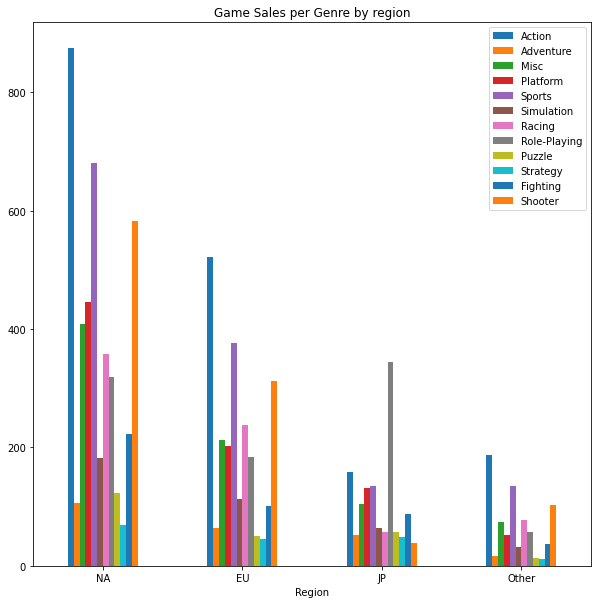

In [ ]:
# 위 데이터는 막대그래프로 보는게 제일 보기 쉬울것으로 보이므로, 막대그래프로 시각화 해 보겠습니다.
import matplotlib.pyplot as plt
genre_barplot = genre_sales.plot.bar(title="Game Sales per Genre by region", rot=0, figsize=(10,10))
print(genre_barplot)
plt.show()

그래프에서 볼 수 있듯, 일본(JP)을 제외하고 모든 지역에서는 액션 게임이 제일 출고량이 많으며, 그 뒤로는 스포츠 게임, 슈팅 게임의 출고량이 많습니다.

일본의 경우, 롤플레잉 게임의 출고량이 1위이며, 그 뒤로 액션, 스포츠 게임의 출고량이 많습니다.

이 결과만을 볼 때, 다음 분기 출시해야 할 게임 장르의 순위는
1. 액션
2. 스포츠
3. 슈팅

으로 생각할 수 있습니다.

(2) 연도별 게임 트렌드

In [ ]:
# 우선 표 안에서 게임이 출시된 고유 연도를 찾습니다.
Year_list = game_data['Year'].unique()
Year_list = Year_list.tolist()
Year_list = sorted(Year_list)
Year_list.pop(36)
Year_list

[1980.0,
 1981.0,
 1982.0,
 1983.0,
 1984.0,
 1985.0,
 1986.0,
 1987.0,
 1988.0,
 1989.0,
 1990.0,
 1991.0,
 1992.0,
 1993.0,
 1994.0,
 1995.0,
 1996.0,
 1997.0,
 1998.0,
 1999.0,
 2000.0,
 2001.0,
 2002.0,
 2003.0,
 2004.0,
 2005.0,
 2006.0,
 2007.0,
 2008.0,
 2009.0,
 2010.0,
 2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0,
 2017.0,
 2020.0]

In [ ]:
# (1)에서 사용한 코드를 수정해, 연도별로 우선 분류한 후 지역별로 출고량을 합치도록 만듭니다.
Genre_1980 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1980)].count()
    Genre_1980.append(j)

Genre_1981 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1981)].count()
    Genre_1981.append(j)
    
Genre_1982 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1982)].count()
    Genre_1982.append(j)

Genre_1983 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1983)].count()
    Genre_1983.append(j)

Genre_1984 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1984)].count()
    Genre_1984.append(j)

Genre_1985 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1985)].count()
    Genre_1985.append(j)
    
Genre_1986 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1986)].count()
    Genre_1986.append(j)

Genre_1987 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1987)].count()
    Genre_1987.append(j)

Genre_1988 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1988)].count()
    Genre_1988.append(j)

Genre_1989 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1989)].count()
    Genre_1989.append(j)

Genre_1990 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1990)].count()
    Genre_1990.append(j)

Genre_1991 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1991)].count()
    Genre_1991.append(j)

Genre_1992 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1992)].count()
    Genre_1992.append(j)

Genre_1993 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1993)].count()
    Genre_1993.append(j)

Genre_1994 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1994)].count()
    Genre_1994.append(j)

Genre_1995 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1995)].count()
    Genre_1995.append(j)

Genre_1996 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1996)].count()
    Genre_1996.append(j)

Genre_1997 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1997)].count()
    Genre_1997.append(j)

Genre_1998 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1998)].count()
    Genre_1998.append(j)

Genre_1999 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1999)].count()
    Genre_1999.append(j)

Genre_2000 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2000)].count()
    Genre_2000.append(j)

Genre_2001 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2001)].count()
    Genre_2001.append(j)

Genre_2002 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2002)].count()
    Genre_2002.append(j)

Genre_2003 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2003)].count()
    Genre_2003.append(j)

Genre_2004 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2004)].count()
    Genre_2004.append(j)

Genre_2005 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2005)].count()
    Genre_2005.append(j)

Genre_2006 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2006)].count()
    Genre_2006.append(j)

Genre_2007 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2007)].count()
    Genre_2007.append(j)

Genre_2008 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2008)].count()
    Genre_2008.append(j)

Genre_2009 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2009)].count()
    Genre_2009.append(j)

Genre_2010 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2010)].count()
    Genre_2010.append(j)

Genre_2011 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2011)].count()
    Genre_2011.append(j)

Genre_2012 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2012)].count()
    Genre_2012.append(j)

Genre_2013 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2013)].count()
    Genre_2013.append(j)

Genre_2014 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2014)].count()
    Genre_2014.append(j)

Genre_2015 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2015)].count()
    Genre_2015.append(j)

Genre_2016 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2016)].count()
    Genre_2016.append(j)

Genre_2017 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2017)].count()
    Genre_2017.append(j)

Genre_2020 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2020)].count()
    Genre_2020.append(j)

In [ ]:
# (1)에서 했던 것처럼, 바로 위에서 계산된 list들을 dataframe으로 만들어, 연도별 각 장르의 출고 수를 표로 보여줍니다.

Year_genre = pd.DataFrame([Genre_1980])
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1981
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1982
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1983
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1984
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1985
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1986
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1987
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1988
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1989
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1990
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1991
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1992
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1993
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1994
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1995
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1996
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1997
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1998
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1999
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2000
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2001
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2002
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2003
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2004
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2005
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2006
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2007
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2008
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2009
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2010
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2011
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2012
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2013
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2014
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2015
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2016
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2017
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2020

In [ ]:
Year_genre.columns = Genre_list
Year_genre['Year'] = Year_list
Year_genre = Year_genre.set_index(['Year'])

In [ ]:
Year_genre

,Action,Adventure,Misc,Platform,Sports,Simulation,Racing,Role-Playing,Puzzle,Strategy,Fighting,Shooter
Year,,,,,,,,,,,,
1980.0,1,0,4,0,0,0,0,0,0,0,1,2
1981.0,25,0,0,3,4,1,1,0,2,0,0,10
1982.0,18,0,1,5,2,0,2,0,3,0,0,5
1983.0,7,1,1,5,1,0,0,0,1,0,0,1
1984.0,1,0,1,1,2,0,3,0,3,0,0,3
1985.0,2,0,0,4,1,1,0,0,4,0,1,1
1986.0,6,0,0,6,3,0,1,1,0,0,0,4
1987.0,2,1,0,2,4,0,0,3,0,0,2,2
1988.0,2,0,0,4,2,1,1,3,1,0,0,1


AxesSubplot(0.125,0.125;0.775x0.755)


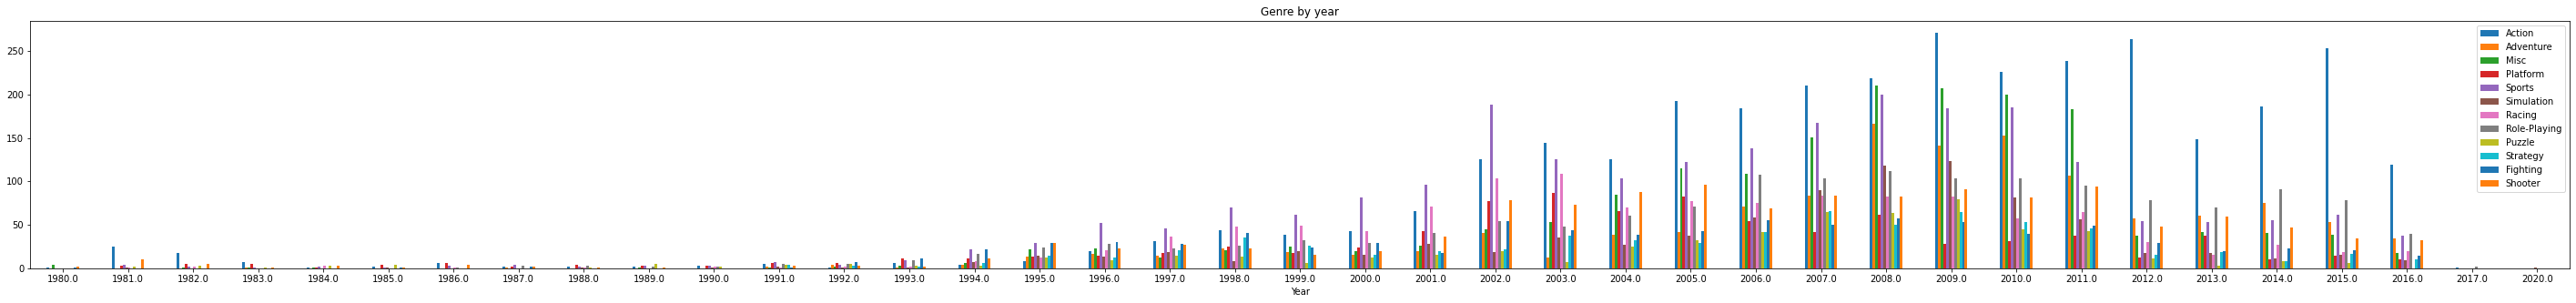

In [ ]:
# 위 데이터를 (1)처럼 막대그래프로 시각화 해 보겠습니다.
year_barplot = Year_genre.plot.bar(title="Genre by year", rot=0, figsize=(50,5))
print(year_barplot)
plt.show()

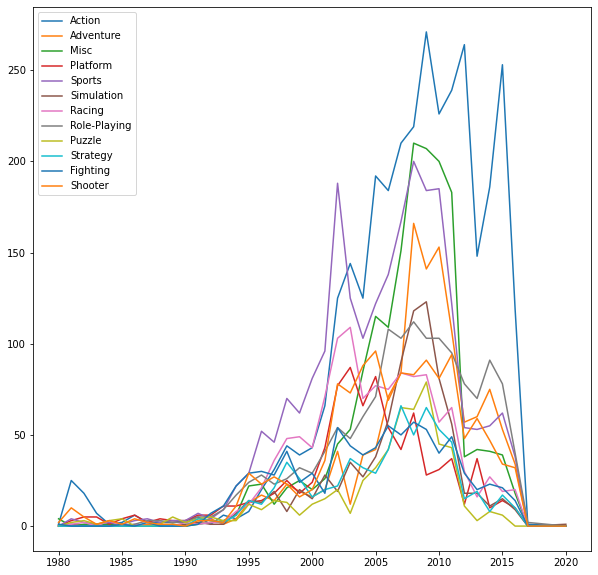

In [ ]:
# 그래프를 보시면 아시겠으나 너무 길이가 길어 한눈에 파악하기도 어렵고, 전체적으로 게임이 점점 많이 나온것 같다는 인상은 있으나 장르간 구별은 힘듭니다.
# 그래서 일반적인 꺽은선 그래프로 이를 표현해 보겠습니다.
plt.figure(figsize=(10,10))
plt.plot(Year_list,Year_genre['Action'], label = 'Action')
plt.plot(Year_list,Year_genre['Adventure'], label = 'Adventure')
plt.plot(Year_list,Year_genre['Misc'], label = 'Misc')
plt.plot(Year_list,Year_genre['Platform'], label = 'Platform')
plt.plot(Year_list,Year_genre['Sports'], label = 'Sports')
plt.plot(Year_list,Year_genre['Simulation'], label = 'Simulation')
plt.plot(Year_list,Year_genre['Racing'], label = 'Racing')
plt.plot(Year_list,Year_genre['Role-Playing'], label = 'Role-Playing')
plt.plot(Year_list,Year_genre['Puzzle'], label = 'Puzzle')
plt.plot(Year_list,Year_genre['Strategy'], label = 'Strategy')
plt.plot(Year_list,Year_genre['Fighting'], label = 'Fighting')
plt.plot(Year_list,Year_genre['Shooter'], label = 'Shooter')
plt.legend()
plt.show()

그래프를 보면, 2020년은 데이터가 부족한 것으로 판단되고, 장르는 1980년~85년 사이 액션게임의 인기가 반짝 상승했다가 전체적으로 출시 수가 감소함을 볼 수 있습니다.

그 후, 모든 게임의 출시 수가 늘어나지만 1995~2000년에는 스포츠 게임이 가장 많이, 그 후로는 액션 게임의 수가 가장 많이 증가함을 알 수 있습니다.

이를 볼 때, 2020년 이후로도 액션 게임이 가장 많이 출고될 거라고 생각할 수 있습니다.



(3) 판매 플랫폼과 게임 출고량



In [ ]:
# 게임이 판매되는 플랫폼 또한 중요하게 생각할 수 있으며, 이를 위해 우선 서로 다른 플랫폼 이름을 확인합니다.
print(game_data['Platform'].unique())

['DS' 'Wii' 'PSP' 'PS3' 'PC' 'PS' 'GBA' 'PS4' 'PS2' 'XB' 'X360' 'GC' '3DS'
 '2600' 'SAT' 'GB' 'NES' 'DC' 'N64' 'XOne' 'SNES' 'WiiU' 'PSV' 'GEN' 'SCD'
 'WS' 'NG' 'TG16' nan '3DO' 'GG' 'PCFX']


In [ ]:
# 확인해 본 결과, 위의 플랫폼들 중 일부는 제조 회사에서 이름을 바꾸어 출시하는 기종들이므로, 회사별로 분류해 보면 다음과 같습니다.
# Nintendo : DS, Wii, GBA, GC, 3DS, GB, NES, N64, SNES, WiiU
# Sony : PSP, PS3, PS, PS4, PS2, PSV, GEN, SCD, GG(game gear)
# Microsoft : XB, X360, XOne
# Atari : 2600
# Sega : SAT, GEN,
# EA : 3DO
# BANDAI : WS(wonderswan)
# SNK : NG(neo-geo)
# NEC Corporation : TG16(turbografix 16), PCFX(PC-FX, 허드슨소프트와 공동개발)
# PC는 일반 개인용 컴퓨터입니다.

In [ ]:
# 우선, 각 플랫폼다의 출고량을 확인하겠습니다.
Platform_list = game_data['Platform'].unique()
Platform_list = Platform_list.tolist()
Platform_list.pop(28)
Platform_list

['DS',
 'Wii',
 'PSP',
 'PS3',
 'PC',
 'PS',
 'GBA',
 'PS4',
 'PS2',
 'XB',
 'X360',
 'GC',
 '3DS',
 '2600',
 'SAT',
 'GB',
 'NES',
 'DC',
 'N64',
 'XOne',
 'SNES',
 'WiiU',
 'PSV',
 'GEN',
 'SCD',
 'WS',
 'NG',
 'TG16',
 '3DO',
 'GG',
 'PCFX']

In [ ]:
# 먼저 플랫폼별 지역에서의 출고량을 확인합니다.
NA_Platform_Sales = []
for i in Platform_list:
  i = game_data.loc[game_data['Platform'] == i, 'NA_Sales'].sum()
  NA_Platform_Sales.append(i)

EU_Platform_Sales = []
for i in Platform_list:
  i = game_data.loc[game_data['Platform'] == i, 'EU_Sales'].sum()
  EU_Platform_Sales.append(i)

JP_Platform_Sales = []
for i in Platform_list:
  i = game_data.loc[game_data['Platform'] == i, 'JP_Sales'].sum()
  JP_Platform_Sales.append(i)

Other_Platform_Sales = []
for i in Platform_list:
  i = game_data.loc[game_data['Platform'] == i, 'Other_Sales'].sum()
  Other_Platform_Sales.append(i)

In [ ]:
platform_sales = pd.DataFrame([NA_Platform_Sales])
platform_sales = platform_sales.append(platform_sales.iloc[-1], ignore_index=True)
platform_sales.iloc[-1] = EU_Platform_Sales
platform_sales = platform_sales.append(platform_sales.iloc[-1], ignore_index=True)
platform_sales.iloc[-1] = JP_Platform_Sales
platform_sales = platform_sales.append(platform_sales.iloc[-1], ignore_index=True)
platform_sales.iloc[-1] = Other_Platform_Sales

In [ ]:
platform_sales.columns = Platform_list
platform_sales['Region'] = Region
platform_sales = platform_sales.set_index(['Region'])

In [ ]:
platform_sales

,DS,Wii,PSP,PS3,PC,PS,GBA,PS4,PS2,XB,X360,GC,3DS,2600,SAT,GB,NES,DC,N64,XOne,SNES,WiiU,PSV,GEN,SCD,WS,NG,TG16,3DO,GG,PCFX
Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NA,390.71,507.71,108.99,392.26,93.28,336.51,187.54,96.80,583.84,186.69,601.05,133.46,78.87,90.60,0.72,114.32,125.94,5.43,139.02,83.19,61.23,38.32,16.20,19.27,1.00,0.00,0.00,0.00,0.0,0.00,0.00
EU,194.65,268.38,68.25,343.71,139.68,213.60,75.25,123.70,339.29,60.95,280.58,38.71,58.52,5.47,0.54,47.82,21.15,1.69,41.06,45.65,19.04,24.23,16.33,5.52,0.36,0.00,0.00,0.00,0.0,0.00,0.00
JP,175.57,69.35,76.75,79.91,0.17,139.82,47.33,14.30,139.20,1.38,12.43,21.58,97.35,0.00,32.26,85.12,98.65,8.56,34.22,0.34,116.55,12.79,20.96,2.67,0.45,1.42,1.44,0.16,0.1,0.04,0.03
Other,60.53,80.61,42.19,141.93,24.86,40.91,7.73,43.36,193.44,8.72,85.54,5.18,12.63,0.91,0.07,8.20,5.31,0.27,4.38,11.92,3.22,6.45,8.45,0.89,0.05,0.00,0.00,0.00,0.0,0.00,0.00


AxesSubplot(0.125,0.125;0.775x0.755)


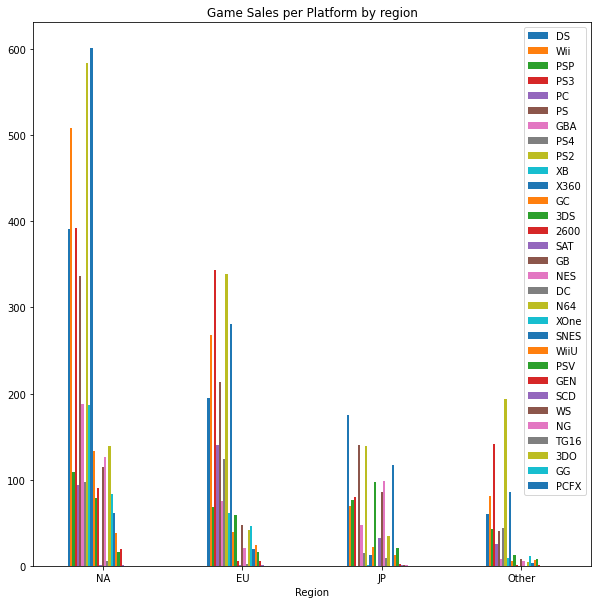

In [ ]:
platform_barplot = platform_sales.plot.bar(title="Game Sales per Platform by region", rot=0, figsize=(10,10))
print(platform_barplot)
plt.show()

In [ ]:
# 그래프를 보면, 플랫폼이 너무 많아서 구분이 힘든것을 확인할 수 있습니다. 따라서 처음에 분류했던 회사별로 묶어서 수를 줄인 후 확인합니다.

In [ ]:
game_data_platform_sorted = game_data.copy()

In [ ]:
game_data_platform_sorted['Platform'].replace({'DS': 'Nintendo', 'Wii': "Nintendo", ''}, inplace=True)